In [ ]:
tinyBert + CNN + xgboost

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/3 — loss: 0.5993
Epoch 2/3 — loss: 0.3183
Epoch 3/3 — loss: 0.2577


C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [23:34:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Ensemble results:
 Accuracy : 0.9209
 Precision: 0.9305
 Recall   : 0.9209
 F1‑score : 0.9221

Full classification report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10400
           1       0.98      0.80      0.88     10400
           2       0.76      0.92      0.83     10400
           3       0.99      0.94      0.96     10400
           4       0.99      0.96      0.97     10400

    accuracy                           0.92     52000
   macro avg       0.93      0.92      0.92     52000
weighted avg       0.93      0.92      0.92     52000



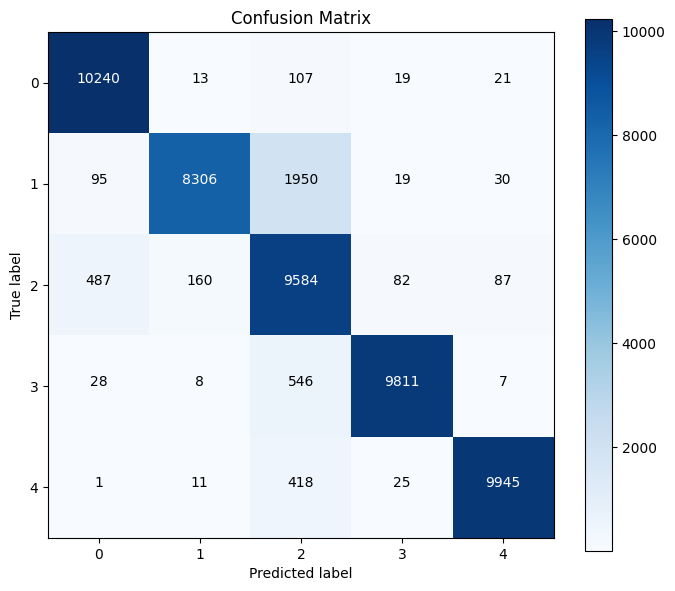

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import itertools

DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRETRAINED = 'prajjwal1/bert-tiny'
MAX_LEN   = 128
BATCH     = 32
EPOCHS    = 3
LR        = 2e-5
DATA_PATH = 'thesis.csv'

df     = pd.read_csv(DATA_PATH)
texts  = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)


class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = self.labels[idx]
        enc   = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)
train_ds  = SentimentDataset(X_train, y_train, tokenizer, MAX_LEN)
test_ds   = SentimentDataset(X_test,  y_test,  tokenizer, MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)


class CNNClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert   = bert_model
        H = bert_model.config.hidden_size
        self.conv1  = nn.Conv1d(in_channels=H, out_channels=100, kernel_size=3, padding=1)
        self.relu   = nn.ReLU()
        self.pool   = nn.AdaptiveMaxPool1d(1)
        self.drop   = nn.Dropout(0.3)
        self.classifier = nn.Linear(100, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = out.last_hidden_state.permute(0,2,1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)
        x = self.drop(x)
        logits = self.classifier(x)
        return logits


bert_model = AutoModel.from_pretrained(PRETRAINED)
cnn_model  = CNNClassifier(bert_model, num_classes=len(set(labels)))
cnn_model.to(DEVICE)

optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    cnn_model.train()
    total_loss = 0
    for batch in train_loader:
        ids   = batch['input_ids'].to(DEVICE)
        mask  = batch['attention_mask'].to(DEVICE)
        lbls  = batch['label'].to(DEVICE)
        optimizer.zero_grad()
        logits = cnn_model(ids, mask)
        loss   = criterion(logits, lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} — loss: {total_loss/len(train_loader):.4f}")

cnn_model.eval()
all_logits = []
with torch.no_grad():
    for batch in test_loader:
        ids  = batch['input_ids'].to(DEVICE)
        mask = batch['attention_mask'].to(DEVICE)
        logits = cnn_model(ids, mask)
        all_logits.append(logits)
all_logits = torch.cat(all_logits, dim=0)
cnn_probs  = torch.softmax(all_logits, dim=1).cpu().numpy()

def extract_cls_embeddings(loader):
    cnn_model.bert.eval()
    feats = []
    with torch.no_grad():
        for batch in loader:
            ids  = batch['input_ids'].to(DEVICE)
            mask = batch['attention_mask'].to(DEVICE)
            out  = cnn_model.bert(ids, mask)
            cls_emb = out.last_hidden_state[:,0,:]
            feats.append(cls_emb.cpu().numpy())
    return np.vstack(feats)

X_train_feats = extract_cls_embeddings(train_loader)
X_test_feats  = extract_cls_embeddings(test_loader)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_feats, y_train)
xgb_probs = xgb_model.predict_proba(X_test_feats)

ensemble_probs = (cnn_probs + xgb_probs) / 2
y_pred = np.argmax(ensemble_probs, axis=1)

acc  = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f"\nEnsemble results:")
print(f" Accuracy : {acc:.4f}")
print(f" Precision: {prec:.4f}")
print(f" Recall   : {rec:.4f}")
print(f" F1‑score : {f1:.4f}\n")
print("Full classification report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
ticks = np.arange(len(set(labels)))
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
             horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [ ]:
tinyBert + bilstm + xgboost

Epoch 1/3 — loss: 0.5256
Epoch 2/3 — loss: 0.3009
Epoch 3/3 — loss: 0.2390


C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [01:45:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Ensemble results:
 Accuracy : 0.9303
 Precision: 0.9356
 Recall   : 0.9303
 F1‑score : 0.9317

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     10400
           1       0.93      0.87      0.90     10400
           2       0.79      0.91      0.85     10400
           3       0.99      0.94      0.97     10400
           4       0.99      0.96      0.97     10400

    accuracy                           0.93     52000
   macro avg       0.94      0.93      0.93     52000
weighted avg       0.94      0.93      0.93     52000



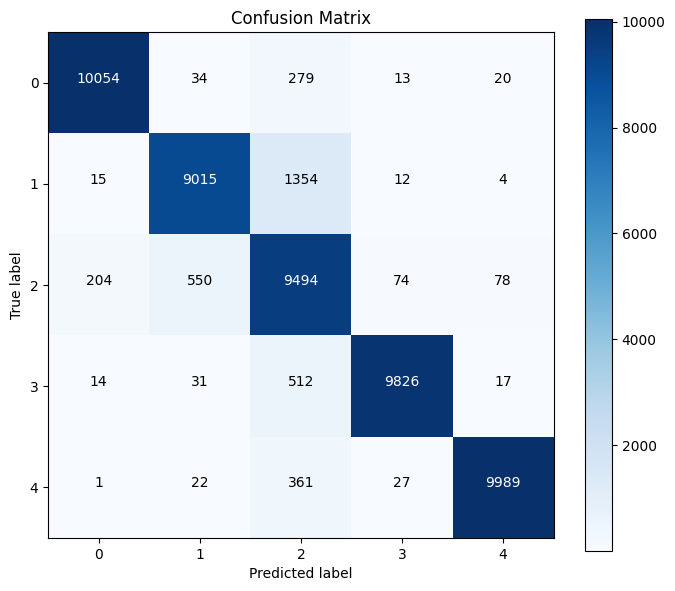

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import itertools

DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRETRAINED = 'prajjwal1/bert-tiny'
MAX_LEN   = 128
BATCH     = 32
EPOCHS    = 3
LR        = 2e-5
DATA_PATH = 'thesis.csv'

df     = pd.read_csv(DATA_PATH)
texts  = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2,
    random_state=42, stratify=labels
)

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids':      enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label':          torch.tensor(self.labels[idx], dtype=torch.long)
        }

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)
train_ds  = SentimentDataset(X_train, y_train, tokenizer, MAX_LEN)
test_ds   = SentimentDataset(X_test,  y_test,  tokenizer, MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

class BiLSTMClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_layers, num_classes):
        super().__init__()
        self.bert = bert_model
        bert_dim = bert_model.config.hidden_size
        self.lstm = nn.LSTM(
            input_size=bert_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3 if num_layers>1 else 0.0
        )
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        lstm_out, _ = self.lstm(out.last_hidden_state)

        avg_pool = torch.mean(lstm_out, dim=1)
        x = self.dropout(avg_pool)
        logits = self.classifier(x)
        return logits

base_bert = AutoModel.from_pretrained(PRETRAINED)
bilstm_model = BiLSTMClassifier(
    bert_model=base_bert,
    hidden_dim=128,
    num_layers=1,
    num_classes=len(set(labels))
).to(DEVICE)

optimizer = torch.optim.AdamW(bilstm_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    bilstm_model.train()
    total_loss = 0
    for batch in train_loader:
        ids   = batch['input_ids'].to(DEVICE)
        mask  = batch['attention_mask'].to(DEVICE)
        lbls  = batch['label'].to(DEVICE)
        optimizer.zero_grad()
        logits = bilstm_model(ids, mask)
        loss   = criterion(logits, lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} — loss: {total_loss/len(train_loader):.4f}")

bilstm_model.eval()
all_logits = []
with torch.no_grad():
    for batch in test_loader:
        ids   = batch['input_ids'].to(DEVICE)
        mask  = batch['attention_mask'].to(DEVICE)
        logits = bilstm_model(ids, mask)
        all_logits.append(logits)
all_logits = torch.cat(all_logits, dim=0)
bilstm_probs = torch.softmax(all_logits, dim=1).cpu().numpy()

def extract_cls(loader):
    base_bert.eval()
    feats = []
    with torch.no_grad():
        for batch in loader:
            ids  = batch['input_ids'].to(DEVICE)
            mask = batch['attention_mask'].to(DEVICE)
            out  = base_bert(ids, mask)
            cls_emb = out.last_hidden_state[:,0,:]
            feats.append(cls_emb.cpu().numpy())
    return np.vstack(feats)

X_train_feats = extract_cls(train_loader)
X_test_feats  = extract_cls(test_loader)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_feats, y_train)
xgb_probs = xgb_model.predict_proba(X_test_feats)

ensemble_probs = (bilstm_probs + xgb_probs) / 2
y_pred = np.argmax(ensemble_probs, axis=1)

acc  = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f"\nEnsemble results:")
print(f" Accuracy : {acc:.4f}")
print(f" Precision: {prec:.4f}")
print(f" Recall   : {rec:.4f}")
print(f" F1‑score : {f1:.4f}\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
ticks = np.arange(len(set(labels)))
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
             horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
